<a href="https://colab.research.google.com/github/Jlokkerbol/masterclass/blob/main/Handling_Multicollinearity_(Python).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handling Multicollinearity

This notebook covers the specific topic of multicollinearity and how applying preprocessing could try to mitigate its potentially harmful effects to model performance.

In [198]:
#import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, RepeatedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [199]:
#load the Sonar data, containing 60 attributes, with the aim to classify 
# objects as Mine or Rock
# more information to be found at: https://datahub.io/machine-learning/sonar
df = pd.read_csv('https://datahub.io/machine-learning/sonar/r/sonar.csv')
df.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,attribute_14,attribute_15,attribute_16,attribute_17,attribute_18,attribute_19,attribute_20,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30,attribute_31,attribute_32,attribute_33,attribute_34,attribute_35,attribute_36,attribute_37,attribute_38,attribute_39,attribute_40,attribute_41,attribute_42,attribute_43,attribute_44,attribute_45,attribute_46,attribute_47,attribute_48,attribute_49,attribute_50,attribute_51,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,Rock
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,Rock
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,Rock
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,Rock
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,Rock


# Data splitting

As always, we start the machine learning pipeline by splitting the data. We use sklearn's StratifiedShuffledSplit to ensure that the distribution of our outcome is similar in both the training and the test set. The objects X and y are assigned the predictors and outcomes in the training (_train) and test (_test) set, respectively.

In [200]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df['Class']):
  strat_train_set = df.loc[train_index]
  strat_test_set = df.loc[test_index]

In [201]:
#check if this resulted in a 70% train set and 30% test set with equal outcome distributions
print('share of observations in the train set:', str(round(len(strat_train_set)/len(df), 3)))
print('share of observations in the test set:', str(round(len(strat_test_set)/len(df), 3)))
print('share of mines in the train set:', str(round(len(strat_train_set.loc[strat_train_set['Class'] == 'Mine'])/len(strat_train_set), 3)))
print('share of mines in the test set:', str(round(len(strat_test_set.loc[strat_test_set['Class'] == 'Mine'])/len(strat_test_set), 3)))

share of observations in the train set: 0.697
share of observations in the test set: 0.303
share of mines in the train set: 0.531
share of mines in the test set: 0.54


In [202]:
# split features and outcome data
X_train = strat_train_set.loc[:,strat_train_set.columns != 'Class']
y_train = strat_train_set['Class']
X_test = strat_test_set.loc[:,strat_test_set.columns != 'Class']
y_test = strat_test_set['Class']

# Running a first model

We start off running a LASSO using all predictors.

In [203]:
sc = StandardScaler()
X_train_prep = sc.fit_transform(X_train)
X_train_prep = pd.DataFrame(data = X_train_prep, columns = X_train.columns)
X_train_prep.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,attribute_14,attribute_15,attribute_16,attribute_17,attribute_18,attribute_19,attribute_20,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30,attribute_31,attribute_32,attribute_33,attribute_34,attribute_35,attribute_36,attribute_37,attribute_38,attribute_39,attribute_40,attribute_41,attribute_42,attribute_43,attribute_44,attribute_45,attribute_46,attribute_47,attribute_48,attribute_49,attribute_50,attribute_51,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60
0,0.034283,0.067601,-0.540083,-1.216550,-1.170987,-0.701419,-0.516137,-0.268162,-0.688366,-0.999476,-1.452884,-0.924677,-0.671054,-0.604662,-0.310763,-0.702617,-0.645532,-0.649335,-0.729284,-0.317455,-0.299591,-0.008835,0.131029,0.311613,0.712183,0.849213,1.234418,0.990376,0.336450,0.242650,0.499052,0.119935,-0.673320,-1.005238,-0.880116,-0.472645,-0.376587,-0.094161,-0.227435,-0.676225,-0.813205,-0.203893,-0.267677,-0.296704,-0.355767,-0.682982,-0.169889,-0.020404,-0.357189,-0.867054,-0.652782,-0.663675,-0.450920,-0.007605,-0.567176,0.293379,-0.654754,-0.351269,-0.475797,0.409389
1,1.858457,0.744916,1.373396,-0.358238,-0.523457,-0.436807,-0.715491,-0.240968,0.468459,-0.183085,0.374547,1.164771,0.629917,-0.636518,-0.257037,0.016645,0.500725,0.756393,0.350793,-0.337814,-1.158652,-1.704743,-1.792821,-2.119814,-1.763306,-1.824993,-1.582754,-0.814761,0.300458,0.757940,1.346200,1.664721,1.237655,1.244888,1.375219,1.686245,2.300661,3.170289,2.803381,2.246552,2.196068,1.719033,1.492587,1.048330,-0.343992,-0.310525,0.067050,0.417722,0.143261,0.217290,-0.202379,0.072554,1.193419,-0.903566,-0.777689,-0.962169,-0.960487,1.190439,0.430963,0.258869
2,-0.413156,-0.874452,-0.317661,-0.726481,0.165531,0.824675,-0.099744,-0.858148,-0.399998,-0.534576,-1.206989,-1.597307,-1.022537,-0.021406,1.047592,1.663665,1.408736,1.217317,1.329867,1.193420,1.298597,1.248310,1.178522,1.341047,1.214272,1.009183,1.000330,0.258084,-0.726925,-1.127596,-0.410590,0.107458,-0.071446,-0.454020,-0.570032,-0.939609,-0.460671,-0.552751,-0.793482,-0.899058,-1.218376,-1.316296,-1.160146,-0.691140,-0.554093,-0.760258,-0.902746,-0.796152,-0.805106,-1.531405,0.202221,-0.063067,-0.325504,-0.572750,-0.679450,-0.317875,-0.510879,-0.365677,-0.122315,-0.211507
3,0.181790,-0.884766,-0.405976,0.173362,0.072745,-0.125597,-0.363406,-0.373390,-0.640584,0.054246,0.543161,0.661013,0.176234,-0.973614,-1.020131,-1.032105,-0.926566,-0.833340,-1.183992,-1.302128,-1.148293,-0.131912,0.729596,0.943510,1.281299,1.269187,1.039683,1.339393,1.141080,0.730304,1.223526,1.265470,0.549450,-0.828538,-1.167940,-0.959243,-1.059660,-1.047394,-0.708022,-1.542171,-0.807474,-1.171051,-0.952890,-0.375005,-0.677426,-1.101387,-0.501603,0.507231,0.334040,-0.210338,-0.843631,-0.702424,-0.158283,0.364563,-0.398765,-0.350915,-0.780644,-0.682664,-0.291371,0.033088
4,0.403051,0.153555,-0.343828,-0.576969,0.191196,0.513465,-0.088490,-0.793119,-1.374078,-1.183483,-1.157810,0.031317,-0.877524,-1.048910,-1.025836,-0.975586,-1.099538,-1.250176,-1.285769,-1.795052,-1.627630,-2.421627,-1.663861,-1.761406,-2.686063,-2.175546,-0.865073,0.131535,0.234472,0.298369,0.932810,0.459575,1.182052,2.005991,2.186749,2.239056,1.780555,1.618582,1.636097,2.054182,1.755938,1.295830,0.917346,0.052361,-0.325399,-0.599440,-0.486175,-0.282651,0.110082,-0.240883,-0.790193,-0.411807,0.775367,0.709164,-0.146149,-0.235273,1.035773,-0.178367,-0.045470,0.051904


In [204]:
logL1_clf = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
lasso_alphas = np.linspace(0.1, 20, 200)
grid = dict()
grid['C'] = lasso_alphas
gscv = GridSearchCV(logL1_clf, grid, scoring='accuracy', cv = cv, n_jobs=-1)
results = gscv.fit(X_train_prep, y_train)

In [205]:
results.best_estimator_

LogisticRegression(C=0.3, penalty='l1', random_state=42, solver='liblinear')

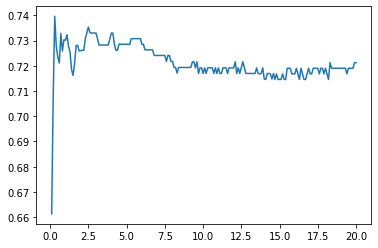

In [206]:
# plot accuracy for different values of C
plt.plot(lasso_alphas, results.cv_results_ ['mean_test_score'])

In [207]:
# get coefficients
results.best_estimator_.coef_

array([[-0.00172171,  0.        ,  0.        , -0.2386276 ,  0.        ,
         0.        ,  0.15498027,  0.08955805,  0.        ,  0.        ,
        -0.35396819, -0.41510276,  0.        ,  0.        ,  0.        ,
         0.47327158,  0.        ,  0.        ,  0.        , -0.18244518,
        -0.22573235, -0.19424865,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.12088375,  0.        ,  0.        ,
         0.26090621,  0.        ,  0.        ,  0.        ,  0.        ,
         0.52276802,  0.        ,  0.        , -0.19630178,  0.        ,
         0.        ,  0.        ,  0.        , -0.34908868,  0.        ,
         0.        ,  0.        , -0.25708019, -0.43333376,  0.        ,
         0.        , -0.41842006,  0.        , -0.25642344,  0.01559149,
        -0.00927758,  0.        , -0.11378141,  0.        ,  0.        ]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


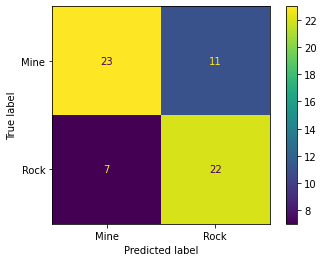

In [208]:
X_test_prep = sc.transform(X_test)
cm = confusion_matrix(y_test, results.best_estimator_.predict(X_test_prep), labels=results.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=results.classes_)
disp.plot()

In [209]:
accuracy_score(results.predict(X_test_prep), y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


0.7142857142857143

# Assessing correlation

To find out how to deal with multicollinearity in the machine learning pipeline, we start off with assessing the correlation between each of the features in our model.

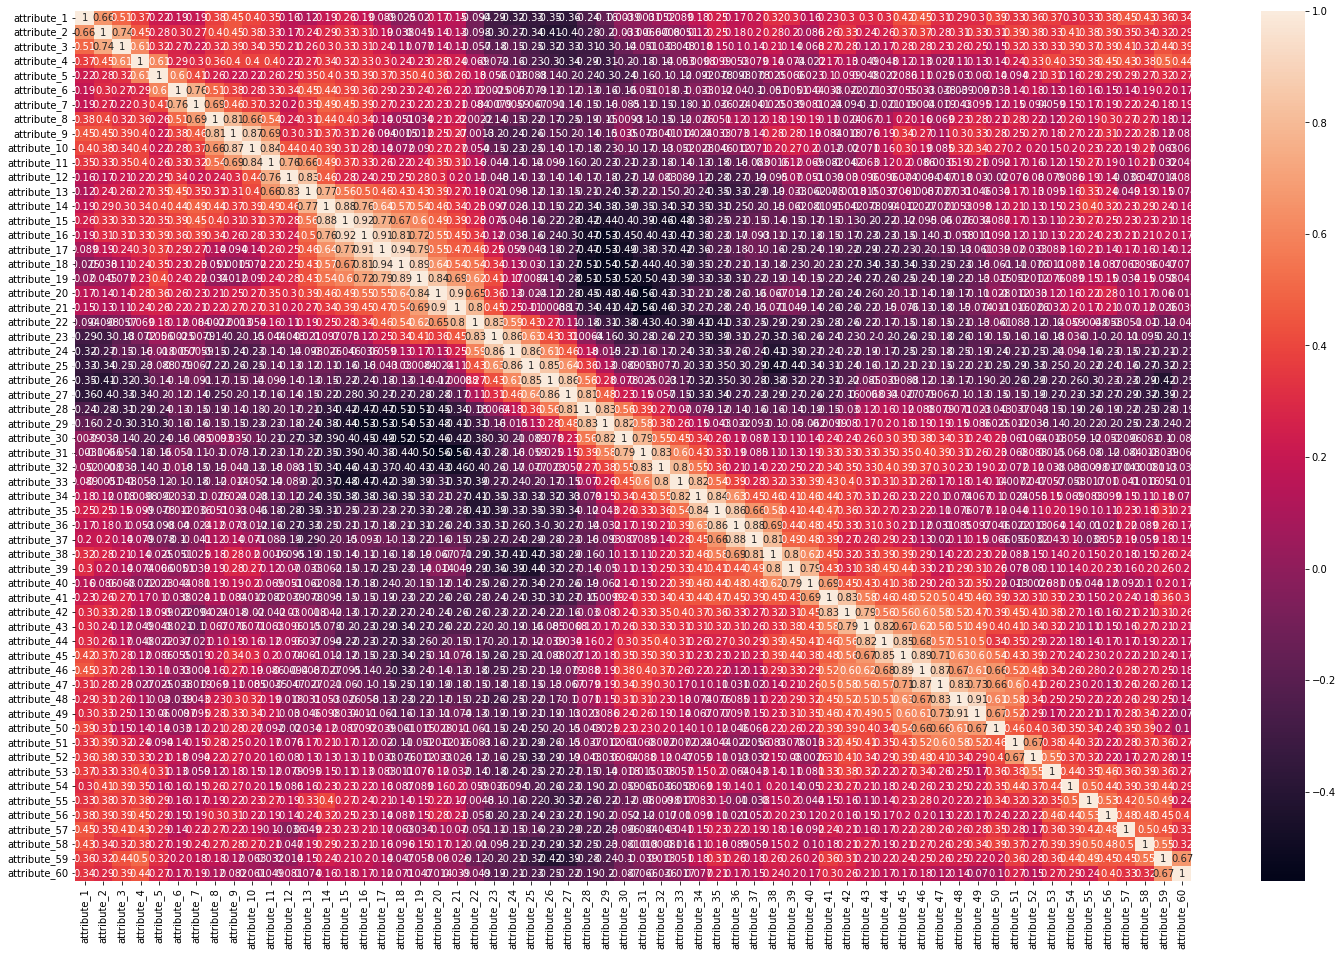

In [210]:
plt.figure(figsize=(25, 16))
sns.heatmap(X_train.corr(), annot=True)

Let's take one cluster of features that seems to be positively correlated and focus on attribute 41 - 50 for the remainder of this example.

In [211]:
subset = X_train.columns[40:50]
X_train[subset].head(5)

,attribute_41,attribute_42,attribute_43,attribute_44,attribute_45,attribute_46,attribute_47,attribute_48,attribute_49,attribute_50
53,0.1552,0.2522,0.2121,0.1801,0.1473,0.0681,0.1091,0.0919,0.0397,0.0093
21,0.6803,0.5898,0.4618,0.3639,0.1492,0.1216,0.1306,0.1198,0.0578,0.0235
75,0.0845,0.0569,0.0855,0.1262,0.1153,0.0570,0.0426,0.0425,0.0235,0.0006
204,0.1562,0.0824,0.1149,0.1694,0.0954,0.0080,0.0790,0.1255,0.0647,0.0179
67,0.6035,0.5155,0.3802,0.2278,0.1522,0.0801,0.0804,0.0752,0.0566,0.0175


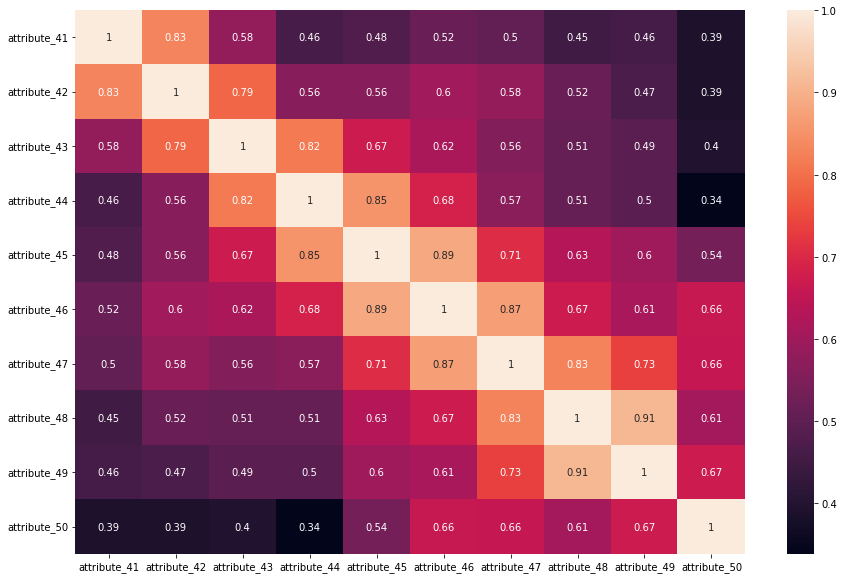

In [212]:
plt.figure(figsize=(15, 10))
sns.heatmap(X_train[subset].corr(), annot=True)

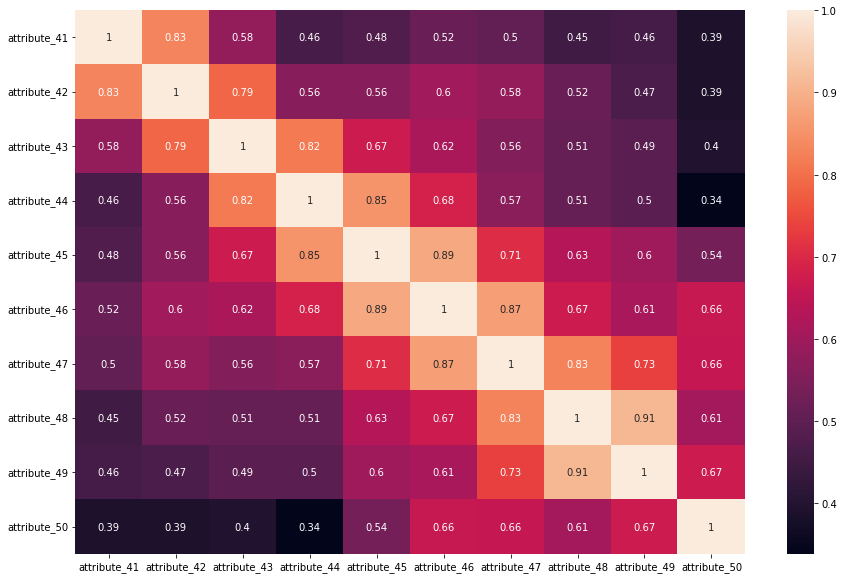

In [213]:
# please note that the scaletransformer does not alter correlations amongst 
# features, such that this is still a problem to be addressed
plt.figure(figsize=(15, 10))
sns.heatmap(X_train_prep[subset].corr(), annot=True)

# Integrating Principal Component Analysis in the Pipeline

This time, we run a model while adding an additional step where instead of using the 10 correlated predictors, we use four principal components of these 10 predictors, which can be seen as four variables that are constructed using these 10 predictors, that capture most of the information in these predictors, but which are no longer correlated. This allows us to see if this translates into better performance, i.e. if using correlated predictors in your model can hurt model performance.

Changing your predictor data in the way described above should be applied on the data not used for validating your model results, but only on the folds of training data used for training your model. This means that, like any preprocessing step, we need to incorporate it in a pipeline.

In [214]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

all_features = X_train.columns
sub_features = X_train.columns[40:50]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

pca_pipeline = Pipeline([
        ('pca', PCA(n_components=5)),
    ])


full_pipeline = ColumnTransformer([
        ("num", num_pipeline, all_features),
        ("sub", pca_pipeline, sub_features)])

X_train_prep = full_pipeline.fit_transform(X_train)

In [215]:
X_train_prep.shape

(145, 65)

In [216]:
PCA_vars = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5']
X_train_prep = pd.DataFrame(data = X_train_prep, columns = [X_train.columns.tolist() + PCA_vars])
X_train_prep.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,attribute_14,attribute_15,attribute_16,attribute_17,attribute_18,attribute_19,attribute_20,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30,attribute_31,attribute_32,attribute_33,attribute_34,attribute_35,attribute_36,attribute_37,attribute_38,attribute_39,attribute_40,attribute_41,attribute_42,attribute_43,attribute_44,attribute_45,attribute_46,attribute_47,attribute_48,attribute_49,attribute_50,attribute_51,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,PCA1,PCA2,PCA3,PCA4,PCA5
0,0.034283,0.067601,-0.540083,-1.216550,-1.170987,-0.701419,-0.516137,-0.268162,-0.688366,-0.999476,-1.452884,-0.924677,-0.671054,-0.604662,-0.310763,-0.702617,-0.645532,-0.649335,-0.729284,-0.317455,-0.299591,-0.008835,0.131029,0.311613,0.712183,0.849213,1.234418,0.990376,0.336450,0.242650,0.499052,0.119935,-0.673320,-1.005238,-0.880116,-0.472645,-0.376587,-0.094161,-0.227435,-0.676225,-0.813205,-0.203893,-0.267677,-0.296704,-0.355767,-0.682982,-0.169889,-0.020404,-0.357189,-0.867054,-0.652782,-0.663675,-0.450920,-0.007605,-0.567176,0.293379,-0.654754,-0.351269,-0.475797,0.409389,-0.166653,-0.027359,0.051213,0.057916,0.004303
1,1.858457,0.744916,1.373396,-0.358238,-0.523457,-0.436807,-0.715491,-0.240968,0.468459,-0.183085,0.374547,1.164771,0.629917,-0.636518,-0.257037,0.016645,0.500725,0.756393,0.350793,-0.337814,-1.158652,-1.704743,-1.792821,-2.119814,-1.763306,-1.824993,-1.582754,-0.814761,0.300458,0.757940,1.346200,1.664721,1.237655,1.244888,1.375219,1.686245,2.300661,3.170289,2.803381,2.246552,2.196068,1.719033,1.492587,1.048330,-0.343992,-0.310525,0.067050,0.417722,0.143261,0.217290,-0.202379,0.072554,1.193419,-0.903566,-0.777689,-0.962169,-0.960487,1.190439,0.430963,0.258869,0.387966,0.358743,0.135107,-0.054969,-0.081192
2,-0.413156,-0.874452,-0.317661,-0.726481,0.165531,0.824675,-0.099744,-0.858148,-0.399998,-0.534576,-1.206989,-1.597307,-1.022537,-0.021406,1.047592,1.663665,1.408736,1.217317,1.329867,1.193420,1.298597,1.248310,1.178522,1.341047,1.214272,1.009183,1.000330,0.258084,-0.726925,-1.127596,-0.410590,0.107458,-0.071446,-0.454020,-0.570032,-0.939609,-0.460671,-0.552751,-0.793482,-0.899058,-1.218376,-1.316296,-1.160146,-0.691140,-0.554093,-0.760258,-0.902746,-0.796152,-0.805106,-1.531405,0.202221,-0.063067,-0.325504,-0.572750,-0.679450,-0.317875,-0.510879,-0.365677,-0.122315,-0.211507,-0.388985,-0.110263,-0.009633,-0.030239,0.018398
3,0.181790,-0.884766,-0.405976,0.173362,0.072745,-0.125597,-0.363406,-0.373390,-0.640584,0.054246,0.543161,0.661013,0.176234,-0.973614,-1.020131,-1.032105,-0.926566,-0.833340,-1.183992,-1.302128,-1.148293,-0.131912,0.729596,0.943510,1.281299,1.269187,1.039683,1.339393,1.141080,0.730304,1.223526,1.265470,0.549450,-0.828538,-1.167940,-0.959243,-1.059660,-1.047394,-0.708022,-1.542171,-0.807474,-1.171051,-0.952890,-0.375005,-0.677426,-1.101387,-0.501603,0.507231,0.334040,-0.210338,-0.843631,-0.702424,-0.158283,0.364563,-0.398765,-0.350915,-0.780644,-0.682664,-0.291371,0.033088,-0.326926,-0.056750,0.002906,-0.035293,-0.090032
4,0.403051,0.153555,-0.343828,-0.576969,0.191196,0.513465,-0.088490,-0.793119,-1.374078,-1.183483,-1.157810,0.031317,-0.877524,-1.048910,-1.025836,-0.975586,-1.099538,-1.250176,-1.285769,-1.795052,-1.627630,-2.421627,-1.663861,-1.761406,-2.686063,-2.175546,-0.865073,0.131535,0.234472,0.298369,0.932810,0.459575,1.182052,2.005991,2.186749,2.239056,1.780555,1.618582,1.636097,2.054182,1.755938,1.295830,0.917346,0.052361,-0.325399,-0.599440,-0.486175,-0.282651,0.110082,-0.240883,-0.790193,-0.411807,0.775367,0.709164,-0.146149,-0.235273,1.035773,-0.178367,-0.045470,0.051904,0.215968,0.342940,0.082052,-0.054459,-0.012839


We should see that the principal components no longer exhibit correlation

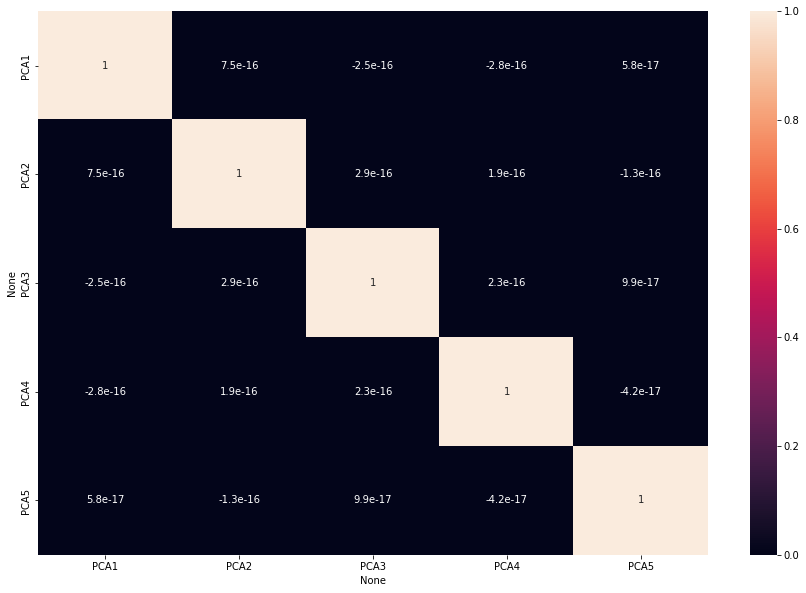

In [217]:
plt.figure(figsize=(15, 10))
sns.heatmap(X_train_prep[PCA_vars].corr(), annot=True)

Before running the LASSO again using the four principal components, I want to get rid of the original 10 features which the principal components were meant to replace.

In [218]:
X_train_prep[subset]

,attribute_41,attribute_42,attribute_43,attribute_44,attribute_45,attribute_46,attribute_47,attribute_48,attribute_49,attribute_50
0,-0.813205,-0.203893,-0.267677,-0.296704,-0.355767,-0.682982,-0.169889,-0.020404,-0.357189,-0.867054
1,2.196068,1.719033,1.492587,1.048330,-0.343992,-0.310525,0.067050,0.417722,0.143261,0.217290
2,-1.218376,-1.316296,-1.160146,-0.691140,-0.554093,-0.760258,-0.902746,-0.796152,-0.805106,-1.531405
3,-0.807474,-1.171051,-0.952890,-0.375005,-0.677426,-1.101387,-0.501603,0.507231,0.334040,-0.210338
4,1.755938,1.295830,0.917346,0.052361,-0.325399,-0.599440,-0.486175,-0.282651,0.110082,-0.240883
...,...,...,...,...,...,...,...,...,...,...
140,-0.763919,-0.738735,-0.472818,-0.234501,-0.643959,-0.695513,-1.170541,-0.829129,-1.156251,-0.485242
141,-0.727242,-1.307183,-1.313121,-0.596738,-0.873272,-0.752600,-0.665807,0.175889,0.569058,0.522739
142,-0.607467,-0.670954,-1.050879,-0.508192,-0.384277,-0.393371,-0.079522,0.062824,0.488876,0.568556
143,2.739353,2.487406,3.688511,4.065507,2.455494,1.985479,2.039702,1.455717,1.188400,-0.004160


In [219]:
X_train_prep = X_train_prep.drop(subset, axis=1)
X_train_prep.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,attribute_14,attribute_15,attribute_16,attribute_17,attribute_18,attribute_19,attribute_20,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30,attribute_31,attribute_32,attribute_33,attribute_34,attribute_35,attribute_36,attribute_37,attribute_38,attribute_39,attribute_40,attribute_51,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,PCA1,PCA2,PCA3,PCA4,PCA5
0,0.034283,0.067601,-0.540083,-1.216550,-1.170987,-0.701419,-0.516137,-0.268162,-0.688366,-0.999476,-1.452884,-0.924677,-0.671054,-0.604662,-0.310763,-0.702617,-0.645532,-0.649335,-0.729284,-0.317455,-0.299591,-0.008835,0.131029,0.311613,0.712183,0.849213,1.234418,0.990376,0.336450,0.242650,0.499052,0.119935,-0.673320,-1.005238,-0.880116,-0.472645,-0.376587,-0.094161,-0.227435,-0.676225,-0.652782,-0.663675,-0.450920,-0.007605,-0.567176,0.293379,-0.654754,-0.351269,-0.475797,0.409389,-0.166653,-0.027359,0.051213,0.057916,0.004303
1,1.858457,0.744916,1.373396,-0.358238,-0.523457,-0.436807,-0.715491,-0.240968,0.468459,-0.183085,0.374547,1.164771,0.629917,-0.636518,-0.257037,0.016645,0.500725,0.756393,0.350793,-0.337814,-1.158652,-1.704743,-1.792821,-2.119814,-1.763306,-1.824993,-1.582754,-0.814761,0.300458,0.757940,1.346200,1.664721,1.237655,1.244888,1.375219,1.686245,2.300661,3.170289,2.803381,2.246552,-0.202379,0.072554,1.193419,-0.903566,-0.777689,-0.962169,-0.960487,1.190439,0.430963,0.258869,0.387966,0.358743,0.135107,-0.054969,-0.081192
2,-0.413156,-0.874452,-0.317661,-0.726481,0.165531,0.824675,-0.099744,-0.858148,-0.399998,-0.534576,-1.206989,-1.597307,-1.022537,-0.021406,1.047592,1.663665,1.408736,1.217317,1.329867,1.193420,1.298597,1.248310,1.178522,1.341047,1.214272,1.009183,1.000330,0.258084,-0.726925,-1.127596,-0.410590,0.107458,-0.071446,-0.454020,-0.570032,-0.939609,-0.460671,-0.552751,-0.793482,-0.899058,0.202221,-0.063067,-0.325504,-0.572750,-0.679450,-0.317875,-0.510879,-0.365677,-0.122315,-0.211507,-0.388985,-0.110263,-0.009633,-0.030239,0.018398
3,0.181790,-0.884766,-0.405976,0.173362,0.072745,-0.125597,-0.363406,-0.373390,-0.640584,0.054246,0.543161,0.661013,0.176234,-0.973614,-1.020131,-1.032105,-0.926566,-0.833340,-1.183992,-1.302128,-1.148293,-0.131912,0.729596,0.943510,1.281299,1.269187,1.039683,1.339393,1.141080,0.730304,1.223526,1.265470,0.549450,-0.828538,-1.167940,-0.959243,-1.059660,-1.047394,-0.708022,-1.542171,-0.843631,-0.702424,-0.158283,0.364563,-0.398765,-0.350915,-0.780644,-0.682664,-0.291371,0.033088,-0.326926,-0.056750,0.002906,-0.035293,-0.090032
4,0.403051,0.153555,-0.343828,-0.576969,0.191196,0.513465,-0.088490,-0.793119,-1.374078,-1.183483,-1.157810,0.031317,-0.877524,-1.048910,-1.025836,-0.975586,-1.099538,-1.250176,-1.285769,-1.795052,-1.627630,-2.421627,-1.663861,-1.761406,-2.686063,-2.175546,-0.865073,0.131535,0.234472,0.298369,0.932810,0.459575,1.182052,2.005991,2.186749,2.239056,1.780555,1.618582,1.636097,2.054182,-0.790193,-0.411807,0.775367,0.709164,-0.146149,-0.235273,1.035773,-0.178367,-0.045470,0.051904,0.215968,0.342940,0.082052,-0.054459,-0.012839


Now we can rerun the LASSO and compare performance

In [220]:
logL1_PCA_clf = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
lasso_alphas = np.linspace(0.1, 20, 200)
grid = dict()
grid['C'] = lasso_alphas
gscv = GridSearchCV(logL1_PCA_clf, grid, scoring='accuracy', cv = cv, n_jobs=-1)
results_pca = gscv.fit(X_train_prep, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [221]:
results_pca.best_estimator_

LogisticRegression(C=0.8999999999999999, penalty='l1', random_state=42,
                   solver='liblinear')

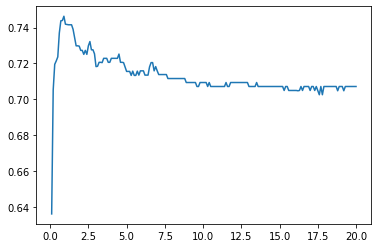

In [222]:
# plot accuracy for different values of C
plt.plot(lasso_alphas, results_pca.cv_results_ ['mean_test_score'])

In [223]:
# get coefficients
results_pca.best_estimator_.coef_

array([[-4.87622557e-02, -6.27596115e-02,  1.54529978e-01,
        -4.56760015e-01,  0.00000000e+00,  4.77803739e-01,
         0.00000000e+00,  1.00761568e+00, -7.09962300e-01,
        -3.46483641e-01, -6.60443560e-01, -4.69891347e-01,
        -5.02987691e-02,  0.00000000e+00,  0.00000000e+00,
         3.09892691e-01,  4.37403126e-01,  0.00000000e+00,
        -2.19164696e-01, -9.67028171e-02,  0.00000000e+00,
        -7.91004427e-01,  0.00000000e+00, -9.75236079e-02,
         0.00000000e+00,  4.60452857e-02,  0.00000000e+00,
        -2.78198506e-03, -5.29499751e-01,  0.00000000e+00,
         5.90573545e-01, -4.40103089e-01,  0.00000000e+00,
         3.68042711e-01,  0.00000000e+00,  0.00000000e+00,
         5.32188779e-01,  0.00000000e+00, -6.64106752e-01,
         0.00000000e+00, -4.75275873e-01, -4.49604606e-01,
        -8.61000228e-02, -4.81723703e-01,  5.04970558e-01,
        -5.35090200e-01,  1.77485557e-01, -4.59308580e-01,
        -5.14995621e-04,  0.00000000e+00, -9.27827768e-0

In [224]:
X_test_prep_pca = full_pipeline.transform(X_test)
X_test_prep_pca = pd.DataFrame(data = X_test_prep_pca, columns = [X_test.columns.tolist() + PCA_vars])
X_test_prep_pca = X_test_prep_pca.drop(subset, axis=1)
X_test_prep_pca.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,attribute_14,attribute_15,attribute_16,attribute_17,attribute_18,attribute_19,attribute_20,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30,attribute_31,attribute_32,attribute_33,attribute_34,attribute_35,attribute_36,attribute_37,attribute_38,attribute_39,attribute_40,attribute_51,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,PCA1,PCA2,PCA3,PCA4,PCA5
0,1.199591,1.810742,5.151290,5.821607,4.939095,2.019589,-0.963077,1.126995,-0.707646,-1.007737,-0.608254,-0.196948,-0.021950,0.163359,0.420952,0.060605,0.434727,0.803396,1.303165,1.375477,1.202172,1.486872,1.228402,0.966821,0.643511,0.036431,-0.142523,-0.884081,-1.511158,-1.673198,-1.667423,-1.563942,-1.301045,-0.716053,0.201273,0.475141,0.362831,0.560555,0.377321,-0.100809,1.049589,1.070338,1.318835,2.046213,-0.132115,1.102877,1.683209,0.959903,0.815183,-0.173877,0.087835,0.181165,0.088310,0.100626,0.096442
1,0.152289,2.054851,2.940159,2.510185,1.877144,1.125900,-0.779799,0.079445,0.242124,1.074922,-0.470865,-1.318953,-1.534224,0.387510,0.969143,0.603192,0.251601,-0.165455,-1.221143,-0.582514,0.625214,1.380977,1.170816,-0.507604,-0.618495,-0.061448,-0.475602,-0.502822,-1.624334,-1.615696,0.353232,0.898566,-0.591379,-0.939730,-0.370859,0.529036,1.104850,0.422113,1.157521,1.723036,0.255658,0.653788,2.001654,0.309427,-0.300526,0.888112,0.262447,0.916677,-0.690960,0.710429,-0.045241,0.182706,-0.058167,-0.130759,-0.096423
2,-0.418073,0.222318,0.431376,0.779718,-0.203640,-0.270385,-0.024182,1.623576,-0.493047,-1.353971,-0.107876,0.081407,-0.666220,0.362604,0.547896,0.650501,0.057960,-0.334886,-0.669301,-1.196418,-1.497734,-2.058789,-1.600598,-0.669949,-1.230788,-1.244618,-0.621654,-0.628968,-0.677735,-0.675602,-0.545763,-0.203070,0.235832,-0.034249,-0.673523,-0.759445,-1.118606,-0.623415,0.038497,0.348806,-0.614612,0.556915,1.081939,0.709164,2.787001,0.095135,2.960097,2.083764,1.675836,0.578724,-0.006207,0.011706,0.001381,0.010689,0.022387
3,-0.536079,-0.200574,-0.438685,-0.297325,-0.183898,-0.844543,-0.848930,-0.828590,-0.980925,-1.103120,-0.553610,0.697507,1.261067,1.219243,1.391817,1.340457,0.252689,-0.327234,-0.981212,-0.930184,-0.513560,0.139417,0.359344,1.013443,1.327355,0.336966,-0.524286,-0.203376,0.958318,0.364786,-0.128670,0.279358,-0.413353,-0.421266,-0.407179,-0.601609,-1.217859,-1.346872,-1.069468,-1.394932,0.049542,-0.305248,0.245834,-0.889782,-0.230355,0.656827,0.388338,-0.322452,-0.752436,-0.870033,-0.221179,-0.125461,-0.044359,0.014414,-0.026112
4,-0.963850,-1.018854,-0.553166,-0.034294,0.935461,0.924529,0.282888,-0.410042,-0.703455,-0.140275,-0.384996,0.032748,0.924085,-0.055000,-0.228035,0.555465,-0.157439,-1.145967,-0.834157,-0.710150,-1.040711,-0.735710,-0.036051,-0.906390,-0.313788,0.742280,0.592197,0.399948,-0.462981,-0.514239,0.153712,0.460499,-0.162654,-0.195003,1.360379,1.529178,0.110146,-1.316107,0.255163,1.712317,0.194587,-0.721799,-0.130413,1.177820,-0.160184,1.119397,1.449413,-0.380086,1.660467,0.691614,-0.018676,0.002738,0.039338,-0.129776,0.006626


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


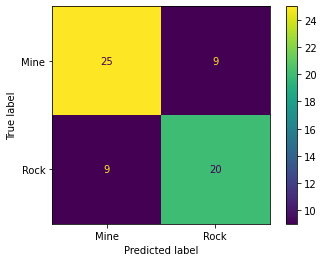

In [225]:
cm = confusion_matrix(y_test, results_pca.best_estimator_.predict(X_test_prep_pca), labels=results_pca.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=results_pca.classes_)
disp.plot()

In [226]:
accuracy_score(results_pca.predict(X_test_prep_pca), y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


0.7142857142857143

# To Conclude

Multicollinearity amongst your predictors can harm your model performance. Addressing multicollinearity, for example by using principal component analysis, should be done within a pipeline to prevent data leakage. 

The toy example presented in this notebook generated a similar performance using 1 of the principal components, instead of 3 of the features that ended up being selected by LASSO in the model without principal components. In use cases where multicollinearity in the feature data is more severe, gains in performance can be expected.
